#**Introduction**
The problem asks to value the intrinsic profit of a gas-fired unit by choosing an optimal ON/OFF schedule given hourly power prices and daily gas prices. This is the operational analog of exercising a heat-rate call option. The plant produces when the spark spread (headroom) is sufficiently positive to cover variable costs and start-up costs under a minimum run-time constraint.

## Given data:

* **Heat rate:** $HR = 10.5 \text{ MMBtu/MWh}$
* **Start-up cost:** $C_{\text{start}} = \$10,000 \text{ per start}$
* **Capacity:** $C = 200 \text{ MW}$
* **Minimum up-time:** $T_{\text{min}} = 16 \text{ hours}$
* **Variable O\&M:** $c_{\text{VOM}} = \$5/\text{MWh}$
* **Gas adder:** $c_{\text{adder}} = \$0.30/\text{MMBtu}$

* $P_{t}^{\text{power}}$: hourly LMP (power price) for hour $t$
* $P_{d}^{\text{gas}}$: daily gas price for date $d$ (constant for 24hrs in a given day)

---
#**Concept**:
### Headroom (spark spread):
Headroom is the instantaneous gross margin per MWh if the plant runs in a given hour. It answers if user turns one MWh of fuel into power right now, how many dollars does the user make after paying for fuel and variable O\&M?

For hour $t$ on date $d(t)$:

$$\text{Headroom}_{t} = P_{t}^{\text{power}} - \left(P_{d(t)}^{\text{gas}} + c_{\text{adder}}\right) HR - c_{\text{VOM}} \quad [\$/\text{MWh}].$$

###Hourly profit when ON:
If the unit is **ON**, we usually run it at full capacity because the heat rate is treated as constant (no partial-load efficiency benefit given in problem). So the hourly cashflow is headroom per MWh times MW.

With a constant heat rate and linear revenue, profit is linear in output; if headroom is positive, more output means more profit, so the best choice is the capacity $C$.

$$m_{t} = \text{Headroom}_{t} \cdot C \quad [\$/\text{hour}].$$



### Start-ups and minimum run time:
Its very energy and resource intensive to turn ON the unit for a single hour and back OFFfor free. Starting the plant costs money and operationally you must keep it ON for at least $T_{\text{min}}$ consecutive hours once started.

This increases the complexity in decsision as the unit should only start when the sum of margins over a block of hours is big enough to cover the start cost, and the block must be at least $T_{\text{min}}$ hours long. $T_{\text{min}}$ is 16 hours as per the given data.

If $u_{t} \in \{0, 1\}$ indicates OFF/ON, the number of starts is

$$N_{\text{starts}} = \sum_{t} \max(u_{t} - u_{t-1}, 0), \quad u_{-1} = 0.$$


If the unit starts at hour $t_{\text{s}}$ (i.e., $u_{t_{\text{s}}-1} = 0, u_{t_{\text{s}}} = 1$), then

$$u_{t_{\text{s}}+k} = 1, \quad k = 0, 1, \dots, T_{\text{min}} - 1.$$

### Objective:

Choose the ON/OFF schedule to maximize total profit: operating margin minus start-up costs.

$$\max_{\{u_{t}\}} \Pi = \sum_{t} u_{t} \text{Headroom}_{t} C - N_{\text{starts}} C_{\text{start}}.$$

---
##**Modelling - Dynamic Programming (DP)**

**Concept.** Because of the minimum up-times, decisions are **path dependent**. Dynamic programming evaluates, at each hour, whether to stay **OFF** or to **start and commit to a block** (of at least $T_{\text{min}}$ hours) and then recurses.

Let

$$S_{k} = \sum_{t=0}^{k-1} m_{t}, \quad \sum_{t=i}^{j} m_{t} = S_{j+1} - S_{i}.$$


Let $dp[i]$ be the **maximum future profit** from hour $i$ onward. Then

$$dp[i] = \max \left( \underbrace{dp[i+1]}_{\text{stay OFF}}, \quad \underbrace{\max_{j \ge i+T_{\text{min}}-1} \left[ (S_{j+1} - S_{i}) - C_{\text{start}} + dp[j+1] \right]}_{\text{start now, run through } j} \right)$$

with boundary $dp[N] = 0$. Reconstruct the schedule by following the recorded choices.

----

## Assumptions

1.  **Intrinsic valuation only:** prices are treated as known (no volatility modeling or discounting within this short horizon).
2.  **Initial state OFF:** $u_{-1} = 0$.
3.  **No min down-time, ramp limits, or outages** (not specified).
4.  **Full-load output when ON** due to constant heat rate.

----
The process flow and methedology is explained above each cell. PLease refer to below explanation.

## Cell 1 -Load and Inspect Input Data:

Read the Excel files and quickly verify structure and column names.

### What the code does

* Uses `files.upload()` (Colab) to ingest `powerPrice.xlsx` and `gasPrice.xlsx`.
* Reads `powerPrice` sheet (columns: `Date`, `HE1..HE24`) and `gasPrice` sheet (`Date`, `gasPrice`).
* Prints `head()` and column lists for a quick schema check.

In [ ]:
# --- Cell 1: Load and inspect input data ---

import pandas as pd
from google.colab import files

# Upload both files (you’ll be prompted to choose them from your computer)
uploaded = files.upload()

# Read the Excel sheets
power_df = pd.read_excel('powerPrice.xlsx', sheet_name='powerPrice')
gas_df = pd.read_excel('gasPrice.xlsx', sheet_name='gasPrice')

# Display quick previews
print("Power Price Data:")
display(power_df.head())

print("\nGas Price Data:")
display(gas_df.head())

# Check structure
print("\nPower Price columns:", list(power_df.columns))
print("Gas Price columns:", list(gas_df.columns))


Saving gasPrice.xlsx to gasPrice.xlsx
Saving powerPrice.xlsx to powerPrice.xlsx
Power Price Data:


,Date,HE1,HE2,HE3,HE4,HE5,HE6,HE7,HE8,HE9,...,HE15,HE16,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24
0,2011-06-01,38.000000,39.355392,34.626365,31.054015,31.344355,33.465550,38.310642,51.612304,59.319929,...,112.077724,124.554282,121.827613,98.418717,83.869277,74.786659,73.448845,66.548534,47.396075,38.831912
1,2011-06-02,33.593616,33.606122,32.354528,31.274359,32.026587,33.142159,36.310319,40.296283,42.311022,...,64.443927,67.976378,67.752257,60.743482,53.301269,49.452922,50.326186,45.565143,36.729084,32.727587
2,2011-06-03,32.293507,30.634917,27.565842,26.813051,27.460818,30.501847,33.817086,37.645471,39.036606,...,60.720871,65.680930,68.232932,63.434124,52.710281,45.995139,45.198169,42.829977,39.620136,36.192705
3,2011-06-04,32.744399,31.973549,31.059064,29.548871,28.779442,28.882158,29.160860,32.504133,35.158368,...,53.444718,60.304318,66.700160,58.616541,49.174129,45.570686,45.360873,45.856755,37.659000,35.700419
4,2011-06-05,32.462243,30.316600,28.457491,27.457401,27.068929,26.974801,26.951645,28.106413,32.179481,...,46.689036,46.604262,47.958736,47.046500,44.374389,44.066582,43.877104,44.135593,33.913758,31.615728



Gas Price Data:


,Date,gasprice
0,2011-06-01,4.825
1,2011-06-02,4.825
2,2011-06-03,4.870
3,2011-06-04,4.940
4,2011-06-05,4.940



Power Price columns: ['Date', 'HE1', 'HE2', 'HE3', 'HE4', 'HE5', 'HE6', 'HE7', 'HE8', 'HE9', 'HE10', 'HE11', 'HE12', 'HE13', 'HE14', 'HE15', 'HE16', 'HE17', 'HE18', 'HE19', 'HE20', 'HE21', 'HE22', 'HE23', 'HE24']
Gas Price columns: ['Date', 'gasprice']


## Cell 2 - Reshape Hourly Prices, Merge Gas and Compute Headroom
This cell Converts the wide power table ($\text{HE}1..\text{HE}24$) to a tidy hourly series, attach the correct daily gas price, and compute headroom.
### Steps

1.  **Datetime parse**
    Ensure `Date` columns are `datetime64[ns]` in both dataframes.

2.  **Transpose HE columns**
    If $\text{HE}1..\text{HE}24$ are columns, we create a long table with columns:
    $$(\text{Date}, \text{HE}, \text{power\_price})$$

3.  **Create hourly timestamp**
    Under the $\text{HE}$ convention, hour-ending $h$ on date $D$ corresponds to timestamp $\text{ts} = D + h \text{ hours}$.

4.  **Merge daily gas**

This will show

* Hourly table with:
    $$(\text{ts}, \text{Date}, \text{hour\_ending}, \text{power\_price}, \text{gasprice}, \text{fuel\_per\_mwh}, \text{headroom\_per\_mwh})$$

* Descriptive stats of `headroom_per_mwh`

In [ ]:
# --- Cell 2: Reshape hourly prices, merge gas, compute headroom ---

import pandas as pd
import numpy as np

# Ensure Date is datetime
power_df['Date'] = pd.to_datetime(power_df['Date'])
gas_df['Date']   = pd.to_datetime(gas_df['Date'])

# Melt HE1..HE24 into long hourly rows
he_cols = [c for c in power_df.columns if c.upper().startswith('HE')]
hourly = power_df.melt(id_vars=['Date'], value_vars=he_cols,
                       var_name='HE', value_name='power_price')

# Derive hour ending number (1..24) and a proper timestamp ending at that hour (HE convention)
hourly['hour_ending'] = hourly['HE'].str.extract(r'HE(\d+)').astype(int)
hourly = hourly.sort_values(['Date','hour_ending']).reset_index(drop=True)
hourly['ts'] = hourly['Date'] + pd.to_timedelta(hourly['hour_ending'], unit='h')

# Merge daily gas price onto each hour of that date
hourly = hourly.merge(gas_df, on='Date', how='left')

# Compute variable fuel $/MWh and headroom $/MWh
HR = 10.5
VOM = 5.0
GAS_ADDER = 0.3

hourly['fuel_per_mwh'] = (hourly['gasprice'] + GAS_ADDER) * HR
hourly['headroom_per_mwh'] = hourly['power_price'] - hourly['fuel_per_mwh'] - VOM

# Keep tidy columns we’ll use later
hourly = hourly[['ts','Date','hour_ending','power_price','gasprice',
                 'fuel_per_mwh','headroom_per_mwh']]

print("Hourly headroom preview:")
display(hourly.head(30))

print("Headroom stats ($/MWh):")
display(hourly['headroom_per_mwh'].describe())


Hourly headroom preview:


,ts,Date,hour_ending,power_price,gasprice,fuel_per_mwh,headroom_per_mwh
0,2011-06-01 01:00:00,2011-06-01,1,38.000000,4.825,53.8125,-20.812500
1,2011-06-01 02:00:00,2011-06-01,2,39.355392,4.825,53.8125,-19.457108
2,2011-06-01 03:00:00,2011-06-01,3,34.626365,4.825,53.8125,-24.186135
3,2011-06-01 04:00:00,2011-06-01,4,31.054015,4.825,53.8125,-27.758485
4,2011-06-01 05:00:00,2011-06-01,5,31.344355,4.825,53.8125,-27.468145
5,2011-06-01 06:00:00,2011-06-01,6,33.465550,4.825,53.8125,-25.346950
6,2011-06-01 07:00:00,2011-06-01,7,38.310642,4.825,53.8125,-20.501858
7,2011-06-01 08:00:00,2011-06-01,8,51.612304,4.825,53.8125,-7.200196
8,2011-06-01 09:00:00,2011-06-01,9,59.319929,4.825,53.8125,0.507429
9,2011-06-01 10:00:00,2011-06-01,10,67.827485,4.825,53.8125,9.014985


Headroom stats ($/MWh):


,headroom_per_mwh
count,37992.000000
mean,-12.060306
std,29.636222
min,-399.693191
25%,-18.858043
50%,-12.175550
75%,-5.309124
max,623.342530


## Cell 3 - Inspect Headroom Values for Validation

This cell validates the calculations before optimization.
The code prints:
* **Top 50 rows** to confirm initial mapping.
* **Middle 50 rows** to check continuity mid-horizon.
* **Last 50 rows** to confirm end alignment.

* For a representative day with $\text{gas} \approx 4.5$, the fuel part should be:

$$(4.5 + 0.3) \times 10.5 \approx 50.4 \text{ \$/MWh}$$
* Positive headroom hours should correspond to high LMPs (scarcity/spike hours).

In [ ]:
# Cell 3: Inspect headroom values for validation

print("Top 50 rows:")
display(hourly.head(50))

# Middle 50
mid_start = len(hourly)//2 - 25
mid_end   = mid_start + 50
print(f"\nMiddle 50 rows ({mid_start}:{mid_end}):")
display(hourly.iloc[mid_start:mid_end])

print("\nLast 50 rows:")
display(hourly.tail(50))


Top 50 rows:


,ts,Date,hour_ending,power_price,gasprice,fuel_per_mwh,headroom_per_mwh
0,2011-06-01 01:00:00,2011-06-01,1,38.000000,4.825,53.8125,-20.812500
1,2011-06-01 02:00:00,2011-06-01,2,39.355392,4.825,53.8125,-19.457108
2,2011-06-01 03:00:00,2011-06-01,3,34.626365,4.825,53.8125,-24.186135
3,2011-06-01 04:00:00,2011-06-01,4,31.054015,4.825,53.8125,-27.758485
4,2011-06-01 05:00:00,2011-06-01,5,31.344355,4.825,53.8125,-27.468145
5,2011-06-01 06:00:00,2011-06-01,6,33.465550,4.825,53.8125,-25.346950
6,2011-06-01 07:00:00,2011-06-01,7,38.310642,4.825,53.8125,-20.501858
7,2011-06-01 08:00:00,2011-06-01,8,51.612304,4.825,53.8125,-7.200196
8,2011-06-01 09:00:00,2011-06-01,9,59.319929,4.825,53.8125,0.507429
9,2011-06-01 10:00:00,2011-06-01,10,67.827485,4.825,53.8125,9.014985



Middle 50 rows (18971:19021):


,ts,Date,hour_ending,power_price,gasprice,fuel_per_mwh,headroom_per_mwh
18971,2013-07-30 12:00:00,2013-07-30,12,33.762406,3.670,41.6850,-12.922594
18972,2013-07-30 13:00:00,2013-07-30,13,35.910498,3.670,41.6850,-10.774502
18973,2013-07-30 14:00:00,2013-07-30,14,36.608415,3.670,41.6850,-10.076585
18974,2013-07-30 15:00:00,2013-07-30,15,37.658864,3.670,41.6850,-9.026136
18975,2013-07-30 16:00:00,2013-07-30,16,38.616963,3.670,41.6850,-8.068037
18976,2013-07-30 17:00:00,2013-07-30,17,39.614663,3.670,41.6850,-7.070337
18977,2013-07-30 18:00:00,2013-07-30,18,37.958326,3.670,41.6850,-8.726674
18978,2013-07-30 19:00:00,2013-07-30,19,36.673795,3.670,41.6850,-10.011205
18979,2013-07-30 20:00:00,2013-07-30,20,35.178383,3.670,41.6850,-11.506617
18980,2013-07-30 21:00:00,2013-07-30,21,35.390733,3.670,41.6850,-11.294267



Last 50 rows:


,ts,Date,hour_ending,power_price,gasprice,fuel_per_mwh,headroom_per_mwh
37942,2015-09-28 23:00:00,2015-09-28,23,25.624963,2.865,33.2325,-12.607537
37943,2015-09-29 00:00:00,2015-09-28,24,23.444321,2.865,33.2325,-14.788179
37944,2015-09-29 01:00:00,2015-09-29,1,23.613273,2.915,33.7575,-15.144227
37945,2015-09-29 02:00:00,2015-09-29,2,22.266123,2.915,33.7575,-16.491377
37946,2015-09-29 03:00:00,2015-09-29,3,20.913425,2.915,33.7575,-17.844075
37947,2015-09-29 04:00:00,2015-09-29,4,20.272541,2.915,33.7575,-18.484959
37948,2015-09-29 05:00:00,2015-09-29,5,21.511584,2.915,33.7575,-17.245916
37949,2015-09-29 06:00:00,2015-09-29,6,23.956625,2.915,33.7575,-14.800875
37950,2015-09-29 07:00:00,2015-09-29,7,31.416334,2.915,33.7575,-7.341166
37951,2015-09-29 08:00:00,2015-09-29,8,30.560323,2.915,33.7575,-8.197177


## Power price vs. Fuel+VOM:

* Below plot shows power price against Fuel+VOM. Most of the time, the blue (Power Price) and orange (Fuel + VOM) lines track close together around $40–60 /MWh.

* That means that under normal conditions, the all-in fuel cost roughly equals the power price, leaving little or no margin. The plant is out-of-the-money most hours — exactly what is noted from the negative mean headroom.

* The occasional sharp blue spikes well above the orange curve are likely due to scarcity or weather-driven events when power prices decouple from fuel costs — system stress, heating demand, or fuel supply bottlenecks which cause cause huge short-term spark spreads.

* The orange curve is smooth and stable, varying slowly with gas prices.
This confirms that fuel cost volatility is far lower than power price volatility.

* This entails when the two curves overlap there is no incentive to dispatch and when blue shoots far above orange it provides profitable headroom opportunity.



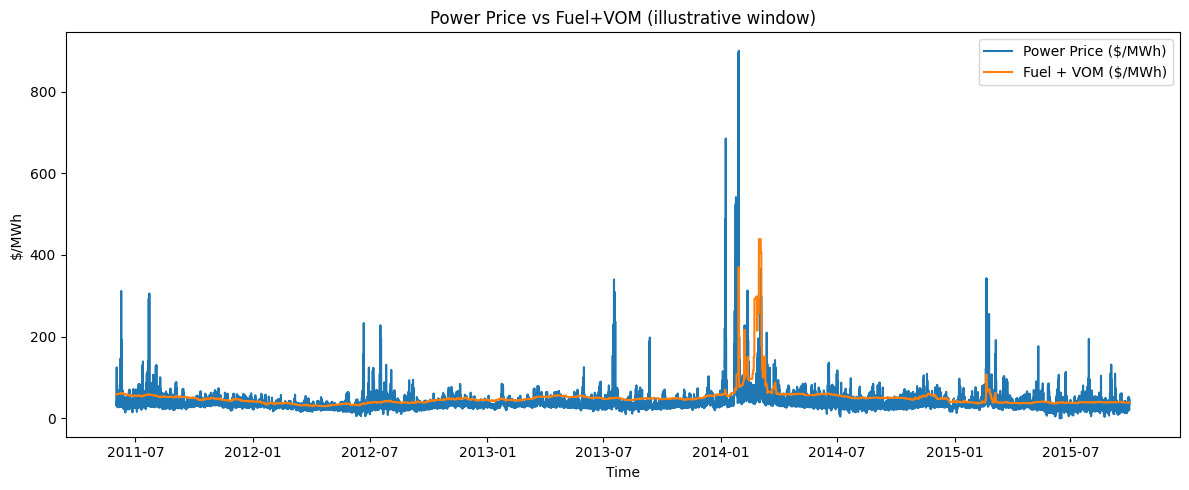

In [ ]:
# --- Cell 4: Power price vs. Fuel+VOM ---
import matplotlib.pyplot as plt
import numpy as np

# pick a readable window
window_hours = 24 * 1583
subset = hourly.iloc[:min(window_hours, len(hourly))].copy()
subset['fuel_plus_vom'] = (subset['gasprice'] + 0.3) * 10.5 + 5

plt.figure(figsize=(12,5))
plt.plot(subset['ts'], subset['power_price'], label='Power Price ($/MWh)')
plt.plot(subset['ts'], subset['fuel_plus_vom'], label='Fuel + VOM ($/MWh)')
plt.legend()
plt.title('Power Price vs Fuel+VOM (illustrative window)')
plt.xlabel('Time')
plt.ylabel('$/MWh')
plt.tight_layout()
plt.show()


# Plot of Headroom vs Price and hourly headroom disctribution histogram:
* This graph shows the hourly headroom (USD/MWh) — the difference between power price and all-in variable cost (fuel + VOM).
* Most hours hover around zero or below, indicating the plant is out of merit and would not run.
* Occasional sharp positive spikes mark periods when power prices surged while gas prices stayed stable showing the profitable dispatch opportunities.
* This histogram shows the distribution of hourly headroom values (USD/MWh).
The distribution is sharply centered just below zero with few on right side indicating the profitable opporuntities.
* Overall, the shape illustrates a highly skewed spread distribution

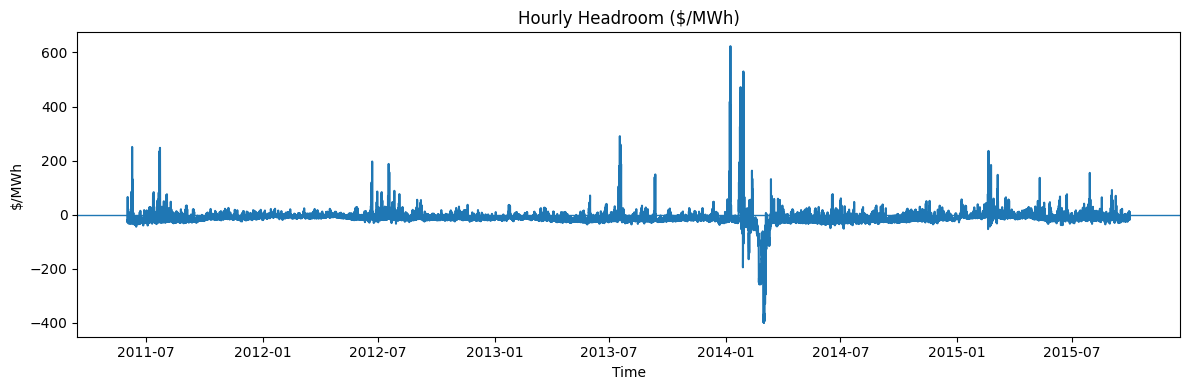

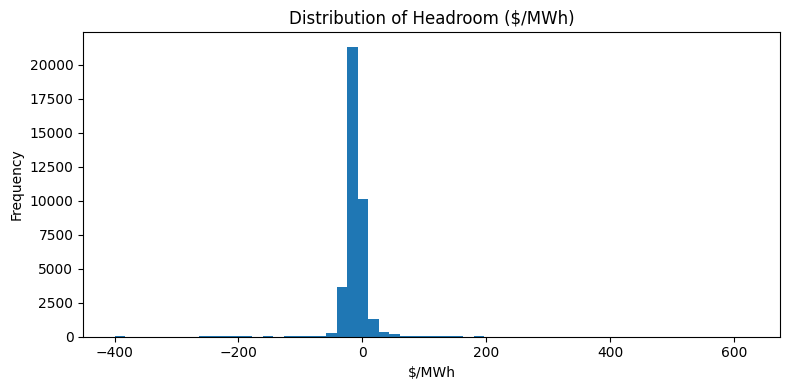

In [ ]:
# --- Cell 5: Headroom time series + histogram ---
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,4))
plt.plot(hourly['ts'], hourly['headroom_per_mwh'])
plt.axhline(0, linewidth=1)
plt.title('Hourly Headroom ($/MWh)')
plt.xlabel('Time'); plt.ylabel('$/MWh')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(hourly['headroom_per_mwh'].dropna().values, bins=60)
plt.title('Distribution of Headroom ($/MWh)')
plt.xlabel('$/MWh'); plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Cell 6 - DP Optimization for Intrinsic Dispatch

This cede cell executes the optimisation model as mentioned in concepts section. It selects ON/OFF schedule $\{u_{t}\}$ that maximizes intrinsic profit with a minimum up-time and start cost.

### Definitions

* Hourly margin at full load:
    $$m_{t} = \text{headroom\_per\_mwh} \cdot C \quad [\$/\text{hour}]$$

* Cumulative sums for fast interval evaluation:
    $$S_{k} = \sum_{t=0}^{k-1} m_{t}, \quad \sum_{t=i}^{j} m_{t} = S_{j+1} - S_{i}.$$


### Dynamic program:

Let $dp[i]$ be the maximum future profit from hour $i$ to end.

### Choices at hour $i$:

1.  Stay OFF this hour:
    $$\text{value} = dp[i + 1].$$

2.  Start now and run through some $j \ge i + T_{\text{min}} - 1$:
 2.  *Start now and run through some $j \ge i + T_{\text{min}} - 1$:*
    $$\text{value}(j) = \left(\sum_{t=i}^{j} m_{t}\right) - C_{\text{start}} + dp[j + 1].$$
    Pick $j$ that maximizes this value.

### Recurrence:

$$dp[i] = \max \left( dp[i + 1], \quad \max_{j \ge i+T_{\text{min}}-1} \left\{ (S_{j+1} - S_{i}) - C_{\text{start}} + dp[j + 1] \right\} \right),$$
with boundary $dp[N] = 0$.

###Schedule reconstruction:

Walk forward:

* If the optimal choice at $i$ is **OFF**, set $u_{i} = 0$ and move to $i + 1$.
* If it is **RUN through $j$**, set $u_{i} = \cdots = u_{j} = 1$, record one **start**, and jump to $j + 1$.

###Output:

* **Operating margin:** $\sum_{t} u_{t} m_{t}$.
* **Starts:** $N_{\text{starts}}$.
* **Total intrinsic profit:**
    $$\Pi = \sum_{t} u_{t} m_{t} - N_{\text{starts}} C_{\text{start}}.$$
* Daily summary: run hours, starts per day, daily profit.

In [ ]:
# --- Cell 6: DP optimization for intrinsic dispatch ---

CAP_MW = 200.0
MIN_RUN = 16
START_COST = 10_000.0

hr = hourly.copy().reset_index(drop=True)
hr['hour_index'] = np.arange(len(hr))  # 0..N-1
margin_per_hour = hr['headroom_per_mwh'].values * CAP_MW  # $/hour if ON
N = len(hr)

# Precompute cumulative sums for O(1) interval sums
cum = np.zeros(N+1)
cum[1:] = np.cumsum(margin_per_hour)

def interval_profit(i, j):
    """Profit from running ON for hours i..j inclusive, before startup.
       Uses cumulative sum (j >= i)."""
    return cum[j+1] - cum[i]

# DP arrays
dp = np.zeros(N+1)              # max profit from hour i..N-1 (dp[N]=0)
choice = np.full(N, -1, int)    # -1 => stay OFF at i; >=0 => run through j (inclusive)

# Backward induction
for i in range(N-1, -1, -1):
    # Option A: stay OFF this hour
    best_val = dp[i+1]
    best_choice = -1

    # Option B: start now (must run at least MIN_RUN)
    j_min = i + MIN_RUN - 1
    if j_min < N:
        # Consider all possible stop times j >= j_min
        # (O(N^2) worst-case; fine for ~thousands of hours)
        best_run = -np.inf
        best_j = None
        # iterate j and compute profit = interval - startcost + dp[next]
        for j in range(j_min, N):
            run_profit = interval_profit(i, j) - START_COST + (dp[j+1] if j+1 <= N else 0.0)
            if run_profit > best_run:
                best_run = run_profit
                best_j = j
        if best_run > best_val:
            best_val = best_run
            best_choice = best_j

    dp[i] = best_val
    choice[i] = best_choice

# Reconstruct schedule
on = np.zeros(N, dtype=int)
i = 0
starts = 0
while i < N:
    if choice[i] == -1:
        # stay OFF this hour
        i += 1
    else:
        j = choice[i]
        on[i:j+1] = 1
        starts += 1
        i = j + 1

hr['on'] = on
hr['profit_hour'] = hr['on'] * margin_per_hour
total_profit = hr['profit_hour'].sum() - starts * 0  # startup already deducted inside DP
# Note: startup was already accounted for in dp; profit_hour is just operating margin.
# For reporting clarity, compute explicit totals:
operating_margin = (hr['on'] * margin_per_hour).sum()
explicit_total_profit = operating_margin - starts * START_COST

print(f"Number of hours: {N}")
print(f"Number of starts: {starts}")
print(f"Operating margin (Σ headroom×MW): ${operating_margin:,.2f}")
print(f"Startup costs: ${starts*START_COST:,.2f}")
print(f"Total intrinsic profit: ${explicit_total_profit:,.2f}")

# Quick views
print("\nFirst 48 hours of schedule:")
display(hr[['ts','power_price','gasprice','headroom_per_mwh','on','profit_hour']].head(48))

print("\nDaily summary:")
daily = (hr.assign(date=hr['ts'].dt.date)
           .groupby('date')
           .agg(run_hours=('on','sum'),
                starts=('on', lambda x: int((x.shift(fill_value=0) < x).sum())),
                day_profit=('profit_hour','sum')))
display(daily.head(10))


Number of hours: 37992
Number of starts: 157
Operating margin (Σ headroom×MW): $14,410,414.16
Startup costs: $1,570,000.00
Total intrinsic profit: $12,840,414.16

First 48 hours of schedule:


,ts,power_price,gasprice,headroom_per_mwh,on,profit_hour
0,2011-06-01 01:00:00,38.000000,4.825,-20.812500,0,-0.0000
1,2011-06-01 02:00:00,39.355392,4.825,-19.457108,0,-0.0000
2,2011-06-01 03:00:00,34.626365,4.825,-24.186135,0,-0.0000
3,2011-06-01 04:00:00,31.054015,4.825,-27.758485,0,-0.0000
4,2011-06-01 05:00:00,31.344355,4.825,-27.468145,0,-0.0000
5,2011-06-01 06:00:00,33.465550,4.825,-25.346950,0,-0.0000
6,2011-06-01 07:00:00,38.310642,4.825,-20.501858,0,-0.0000
7,2011-06-01 08:00:00,51.612304,4.825,-7.200196,1,-1440.0392
8,2011-06-01 09:00:00,59.319929,4.825,0.507429,1,101.4858
9,2011-06-01 10:00:00,67.827485,4.825,9.014985,1,1802.9970



Daily summary:


,run_hours,starts,day_profit
date,,,
2011-06-01,16,1,79823.0940
2011-06-02,0,0,0.0000
2011-06-03,0,0,0.0000
2011-06-04,0,0,0.0000
2011-06-05,0,0,0.0000
2011-06-06,0,0,0.0000
2011-06-07,16,1,90156.4718
2011-06-08,16,1,256503.2792
2011-06-09,16,1,134297.3022


##Headroom with dispatch overlay

This plot shows dispatch overlayed on Headroom. Each marker shows an hour when the plant was turned ON according to the dynamic-programming optimization.The pattern confirms that the model only dispatches during sustained profitable windows, avoiding noise and brief, unprofitable price blips

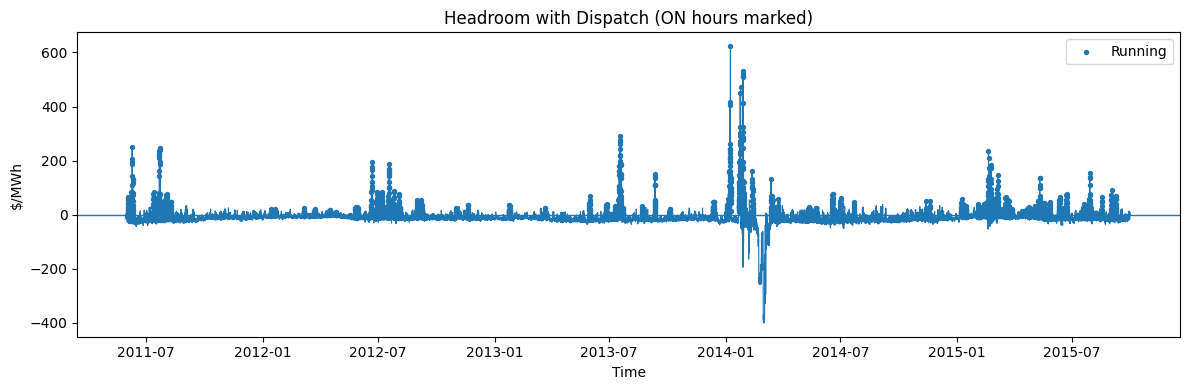

In [ ]:
# --- Cell 7: Headroom with dispatch overlay ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,4))
plt.plot(hr['ts'], hr['headroom_per_mwh'], linewidth=0.8)
plt.axhline(0, linewidth=1)

# Simple shading using where on==1 (baseline fill against 0)
on_mask = hr['on'].values.astype(bool)
x = hr['ts'].values
y = hr['headroom_per_mwh'].values
# To "shade" ON hours, we can plot markers or a stepped line to indicate ON periods.
# Here: draw vertical markers at ON hours for clarity.
plt.scatter(hr.loc[on_mask, 'ts'], hr.loc[on_mask, 'headroom_per_mwh'], s=8, label='Running')

plt.title('Headroom with Dispatch (ON hours marked)')
plt.xlabel('Time'); plt.ylabel('$/MWh')
plt.legend()
plt.tight_layout()
plt.show()


## Plot: Cumulative profit curve
This plot shows the cumulative operating margin (before subtracting startup costs) earned by the generator over time. The curve increases only during profitable dispatch periods and remains flat when the plant is idle, so each upward step represents a sustained profitable run. Overall, this figure illustrates how a merchant generator's intrinsic value is driven by a handful of high-spread episodes rather than continuous operation.

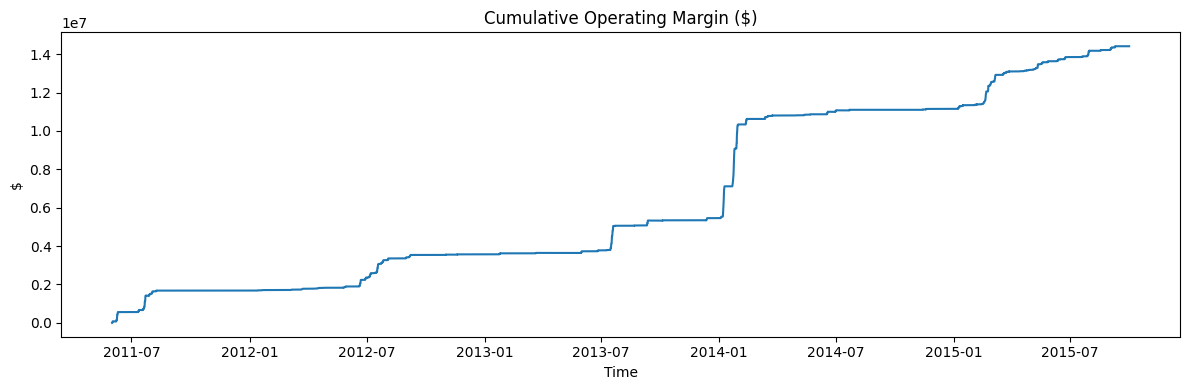

Operating margin: $14,410,414.16
Startup costs:    $1,570,000.00
Net intrinsic:    $12,840,414.16


In [ ]:
# --- Cell 8: Cumulative profit curve ---
import matplotlib.pyplot as plt
import numpy as np

hr = hr.copy()
hr['cum_operating_margin'] = hr['profit_hour'].cumsum()

plt.figure(figsize=(12,4))
plt.plot(hr['ts'], hr['cum_operating_margin'])
plt.title('Cumulative Operating Margin ($)')
plt.xlabel('Time'); plt.ylabel('$')
plt.tight_layout()
plt.show()

# Optional: annotate startup cost on the final number
final_operating = float(hr['cum_operating_margin'].iloc[-1])
# 'starts' and START_COST were computed in Cell 4
try:
    net_profit = final_operating - starts * START_COST
    print(f"Operating margin: ${final_operating:,.2f}")
    print(f"Startup costs:    ${starts*START_COST:,.2f}")
    print(f"Net intrinsic:    ${net_profit:,.2f}")
except NameError:
    pass


# **Results and Discussion**

### **1. Overview of results**

The dispatch optimization was performed for **37,992 hourly observations** (≈ 4.3 years of data).  
Using the dynamic programming model that enforces a **16-hour minimum run** and a **\$10,000 startup cost**, the unit achieved:


\begin{array}{ll}
\textbf{Total hours analyzed:} & 37{,}992 \\
\textbf{Optimal number of starts:} & 157 \\
\textbf{Operating margin } (\Sigma \text{ Headroom} \times MW): & \$14{,}410{,}414.16 \\
\textbf{Startup costs:} & \$1{,}570{,}000.00 \\
\textbf{Total intrinsic profit:} & \mathbf{\$12{,}840{,}414.16}
\end{array}


This means the gas-fired unit would have earned roughly **\$12.8 million in intrinsic value** by optimally turning ON and OFF given the historical power and gas prices.


### **2. Interpretation of headroom behavior**

The **headroom distribution** is sharply centered below zero (mean ≈ –12 \$/MWh, std ≈ 30 \$/MWh), confirming that the unit is **out of merit** most of the time.  
Only a small fraction of hours show positive spreads large enough to cover fuel and variable costs, consistent with the role of a **mid-merit or peaking gas plant**.  
The histogram shows a long right tail: rare hours with headroom > 100 \$/MWh — the key profit drivers.

### **3. Temporal patterns in market prices**

The *Power Price vs Fuel + VOM* plot shows that both prices normally track closely, with **occasional sharp decouplings** where power price surges above fuel cost.  
These episodes correspond to **scarcity events** or **fuel supply shocks** — notably the **winter 2013–2014 polar vortex**, when LMPs spiked above \$800/MWh.  
Such events create temporary windows of strong spark spreads, which the dispatch model captures as profitable ON periods.



### **4. Dispatch and operational behavior**

The **dispatch overlay plot** demonstrates that the model only runs the unit during clusters of sustained positive headroom.  
Short, isolated price spikes are ignored because they cannot amortize the \$10,000 startup cost or satisfy the 16-hour minimum run.  
A total of **157 starts** across four years implies roughly one start every 10 days, typical for an economic peaker.


### **5. Profit accumulation over time**

The **cumulative operating margin curve** rises in discrete steps rather than smoothly.  
Each upward step represents one or more profitable runs; long flat sections indicate idle periods when market spreads were insufficient.  
The steepest climbs occur in **early 2014** and **early 2015**, aligning with the major power-price volatility seen in the data.


### **6. Economic interpretation**

The results highlight key principles from Lecture 12 (Tolling and Dispatch):

- **Intrinsic vs extrinsic value:** this analysis computes *intrinsic* profit only, assuming perfect foresight of prices. Real-world extrinsic value would be higher due to uncertainty and optionality but harder to realize operationally.  
- **Heat-rate optionality:** the generator behaves like a *heat-rate call option*, exercised only when spark spreads exceed a threshold set by startup and run-time constraints.  
- **Volatility leverage:** profits are highly sensitive to spread volatility — more price excursions above cost linearly increase intrinsic value.


# **Conclusion**

* This exercise demonstrated the complete process of valuing and dispatching a gas-fired generator under real market conditions using the **intrinsic (deterministic) valuation** framework.

* By combining hourly power prices and daily gas prices with the plant’s physical characteristics, we formulated a **dynamic optimization problem** that maximizes total profit subject to start-up cost and minimum run-time constraints.

* The computed results show that over 37,992 hours, the unit achieved an **intrinsic profit of approximately \$12.84 million** with 157 optimal starts.

* The **headroom analysis** revealed that the plant is unprofitable in most hours and only economically viable during rare, high-spread periods.  
These brief events—such as the extreme price volatility of winter 2013-2014—generate nearly all of the unit’s value.

* The **visualizations** reinforce this behavior: power and fuel costs typically move in tandem, and the dispatch schedule activates only during sustained intervals of large positive headroom.  

* The **cumulative profit curve** confirms that value accrues in sharp bursts rather than continuously, a hallmark of merchant gas generation.

* Overall, this study validates the lecture concepts of **heat-rate optionality** and **tolling-deal economics**: the generator behaves like a call option on the power-gas spread, whose intrinsic value arises from flexibility to operate selectively in profitable conditions.  

* Future extensions could estimate **extrinsic value** by introducing stochastic power and gas dynamics and evaluating the expected uplift from volatility and correlation effects.
